In [82]:
import numpy as np
import matplotlib.pyplot as plt
from qreservoirpy import QReservoir, Layers, utilities

from qiskit.extensions import HamiltonianGate


## Initialization

In [83]:
n_qubits = 5
SHOTS = 6000

timeseries_step = [3, 3, 6, 3, 3, 6, 3, 5, 1, 2, 6, 6, 4, 4, 4, 4, 4, 3, 3, 7, 7, 5, 5, 4, 2, 0]

timeseries = timeseries_step * 5


num_encode = 3
encoder = {}
for i in range(2 ** num_encode):
    encoder[i] = ['0'] * num_encode + list(bin(i)[2:])
    encoder[i] = "".join(encoder[i][-num_encode:])
print(encoder)

T = 10#s
H = utilities.random_ising_H(num_qubits=n_qubits, num_terms=80)
UT = HamiltonianGate(H, T, label="UT")


{0: '000', 1: '001', 2: '010', 3: '011', 4: '100', 5: '101', 6: '110', 7: '111'}


In [84]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
models = np.array([
    SVC(kernel=ker) for ker in ['linear', 'poly', 'rbf', 'sigmoid']
] + [
    RidgeClassifier(alpha=alph) for alph in np.linspace(0, 1e-3, 9)
] + [
    KNeighborsClassifier(n_neighbors=n) for n in range(1, 10)
], dtype=object)



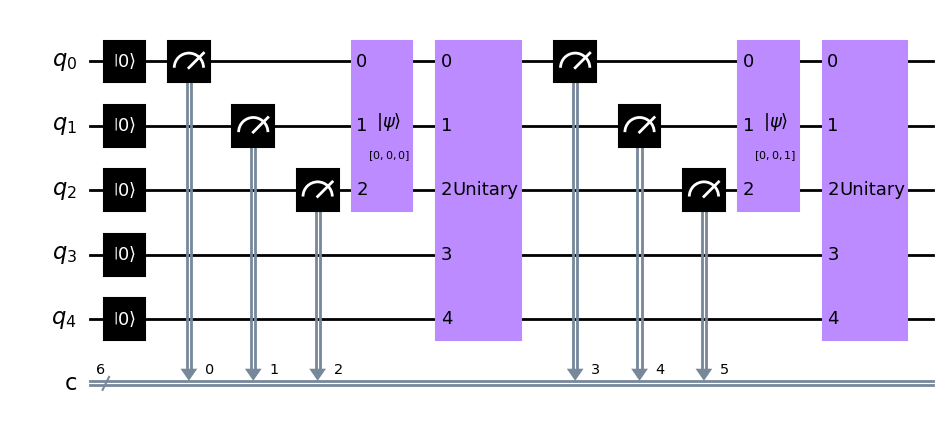

In [85]:

def build_method(circuit, timestep, encoding, reservoir):
    circuit.measure(range(3))
    circuit.initialize(encoding[timestep], range(3))
    circuit.unitary(reservoir, circuit.qubits)

qres = QReservoir(qubits=n_qubits, layers=[
    Layers.Reset(),
    Layers.Timeseries(build_method=build_method, 
                      encoding = encoder,
                      reservoir = UT)
])
qres.circuit.draw('mpl')


## Running

In [86]:
states = qres.run(
    timeseries=timeseries, 
    shots=SHOTS
)


Simulating: 100%|██████████| 1/1 [00:12<00:00, 12.28s/it]


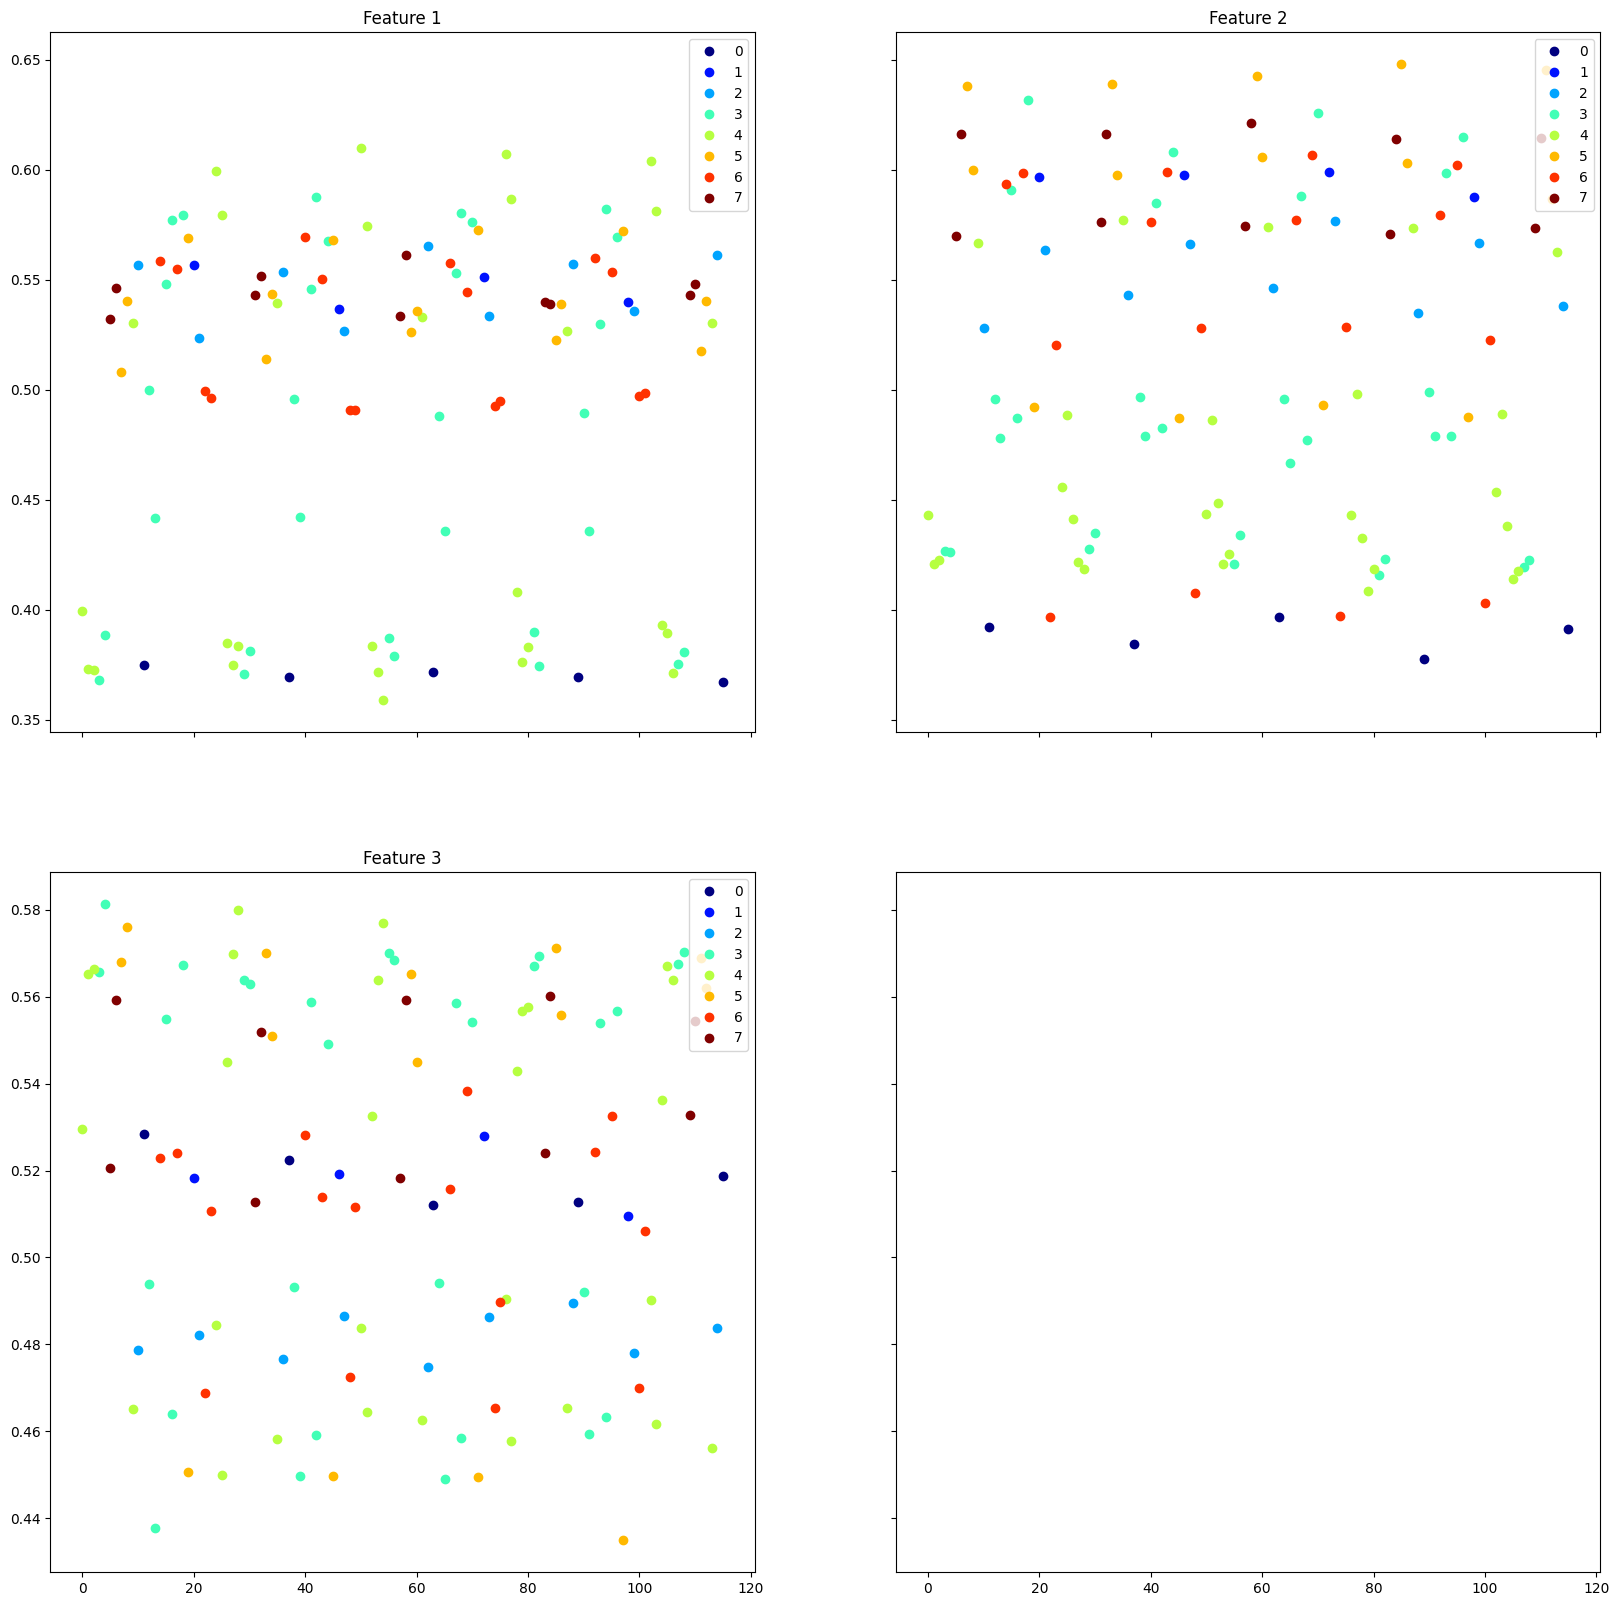

In [87]:
WARMUP = 0.1 # 10%
warmup_idx = int(len(states) * WARMUP)

xstates = states[:-1][warmup_idx:]
target = timeseries[1:][warmup_idx:]
fig, ax = utilities.result_plotter(xstates, target)

Text(0, 0.5, 'state 2')

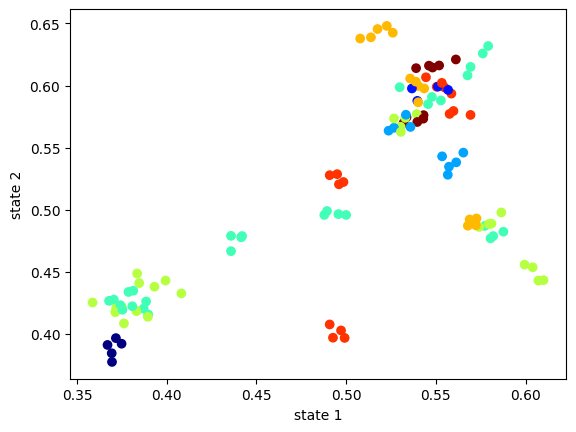

In [88]:



cmap = plt.get_cmap('jet', len(np.unique(timeseries)))

plt.scatter(xstates[:, 0], xstates[:, 1], cmap=cmap, c=target)

plt.xlabel("state 1")
plt.ylabel("state 2")


## Training

In [89]:


results = utilities.stress_test_models(xstates, target, models, test_to_train_ratio=1/3)
sorting = np.flip(np.argsort(results))
for model, res in zip(models[sorting], results[sorting]):
    print(f'Score of {model}: {res}')
    

model = models[sorting][0]


Score of KNeighborsClassifier(n_neighbors=1): 0.7651282051282047
Score of KNeighborsClassifier(n_neighbors=2): 0.726410256410256
Score of KNeighborsClassifier(n_neighbors=3): 0.6946153846153845
Score of KNeighborsClassifier(n_neighbors=4): 0.601025641025641
Score of SVC(kernel='poly'): 0.5387179487179489
Score of KNeighborsClassifier(): 0.5361538461538463
Score of KNeighborsClassifier(n_neighbors=6): 0.4807692307692305
Score of KNeighborsClassifier(n_neighbors=7): 0.4448717948717947
Score of KNeighborsClassifier(n_neighbors=8): 0.41820512820512773
Score of KNeighborsClassifier(n_neighbors=9): 0.39615384615384586
Score of SVC(): 0.366410256410256
Score of SVC(kernel='linear'): 0.2082051282051279
Score of RidgeClassifier(alpha=0.001): 0.2079487179487176
Score of RidgeClassifier(alpha=0.000875): 0.20769230769230734
Score of RidgeClassifier(alpha=0.00075): 0.20743589743589708
Score of RidgeClassifier(alpha=0.000625): 0.20717948717948687
Score of RidgeClassifier(alpha=0.0005): 0.20717948717

## Predicting

In [90]:
predict_from = timeseries_step
num_preds = len(timeseries_step)


pred_states, preds = qres.predict(
    num_pred=num_preds,
    model=model,
    shots=SHOTS,
    from_series=predict_from
)


Predicting: 100%|██████████| 1027/1027 [01:48<00:00,  9.44it/s]


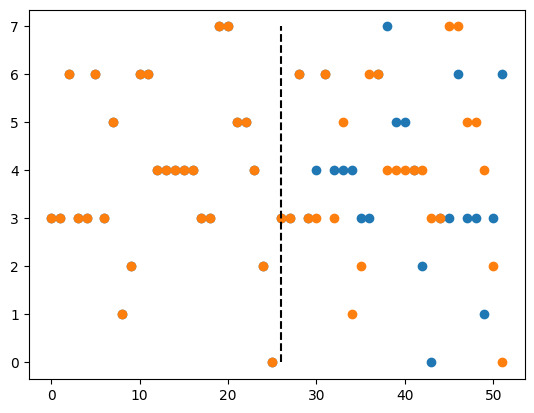

In [95]:
true_values = timeseries

pred_plot = np.append(predict_from[-num_preds:], preds)
true_plot = np.append(predict_from[-num_preds:], true_values)

minlen = min(len(pred_plot), len(true_plot))

plt.scatter(np.arange(minlen), pred_plot[:minlen], label="Predictions")
plt.vlines(len(predict_from[-num_preds:]), ymin=np.min(target), ymax=np.max(target), colors='k', linestyles='dashed')
plt.scatter(np.arange(minlen), true_plot[:minlen], label="True timeseries")
# plt.legend()

In [92]:
from qreservoirpy import music


# 6 = 2 * E
# 0 = 2 * C

music_encoding = {
    0: (52, 1),
    1: (52, 1/4),
    2: (54, 1/4),
    3: (56, 1/4),
    4: (57, 1/4),
    5: (59, 1/4),
    6: (56, 1/2),
    7: (56, 1/8)
}



notes = [music_encoding[elem] for elem in pred_plot]
# music.gen_audio(notes, filename="music/discrete8.wav", BPM=160)